# Hierarchical Linear Regression (Pigs dataset)

## Prepare Notebook

In [1]:
import arviz_stats as azs
import arviz_plots as azp
import bambi as bmb
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
import statsmodels.api as sm

azp.style.use("arviz-variat")
SEED = 2611

We'll use a dataset included with `statsmodels` containing [the growth curve of pigs](https://www.rdocumentation.org/packages/doBy/versions/4.6-2/topics/data-dietox). 

This model aims to analyse how pig weight changes over time. We know each pig's growth is unique; at the same time, these pigs belong to the same species/population, so there also lies some similarity among them. Hierarchical models are beneficial for these kinds of problems. 

This notebook will demonstrate how to perform a Bayesian hierarchical linear regression in Bambi and PyMC.

## Load data & EDA

In [2]:
# Load up data from statsmodels
df = sm.datasets.get_rdataset("dietox", "geepack").data
df.describe()

Pig      Litter       Start      Weight        Feed        Time
count   861.000000  861.000000  861.000000  861.000000  789.000000  861.000000
mean   6238.319396   12.135889   25.672701   60.725769   80.728645    6.480836
std    1323.845928    7.427252    3.624336   24.978881   52.877736    3.444735
min    4601.000000    1.000000   15.000000   15.000000    3.300003    1.000000
25%    4857.000000    5.000000   23.799990   38.299990   32.800003    3.000000
50%    5866.000000   11.000000   25.700000   59.199980   74.499996    6.000000
75%    8050.000000   20.000000   27.299990   81.199950  123.000000    9.000000
max    8442.000000   24.000000   35.399990  117.000000  224.500000   12.000000

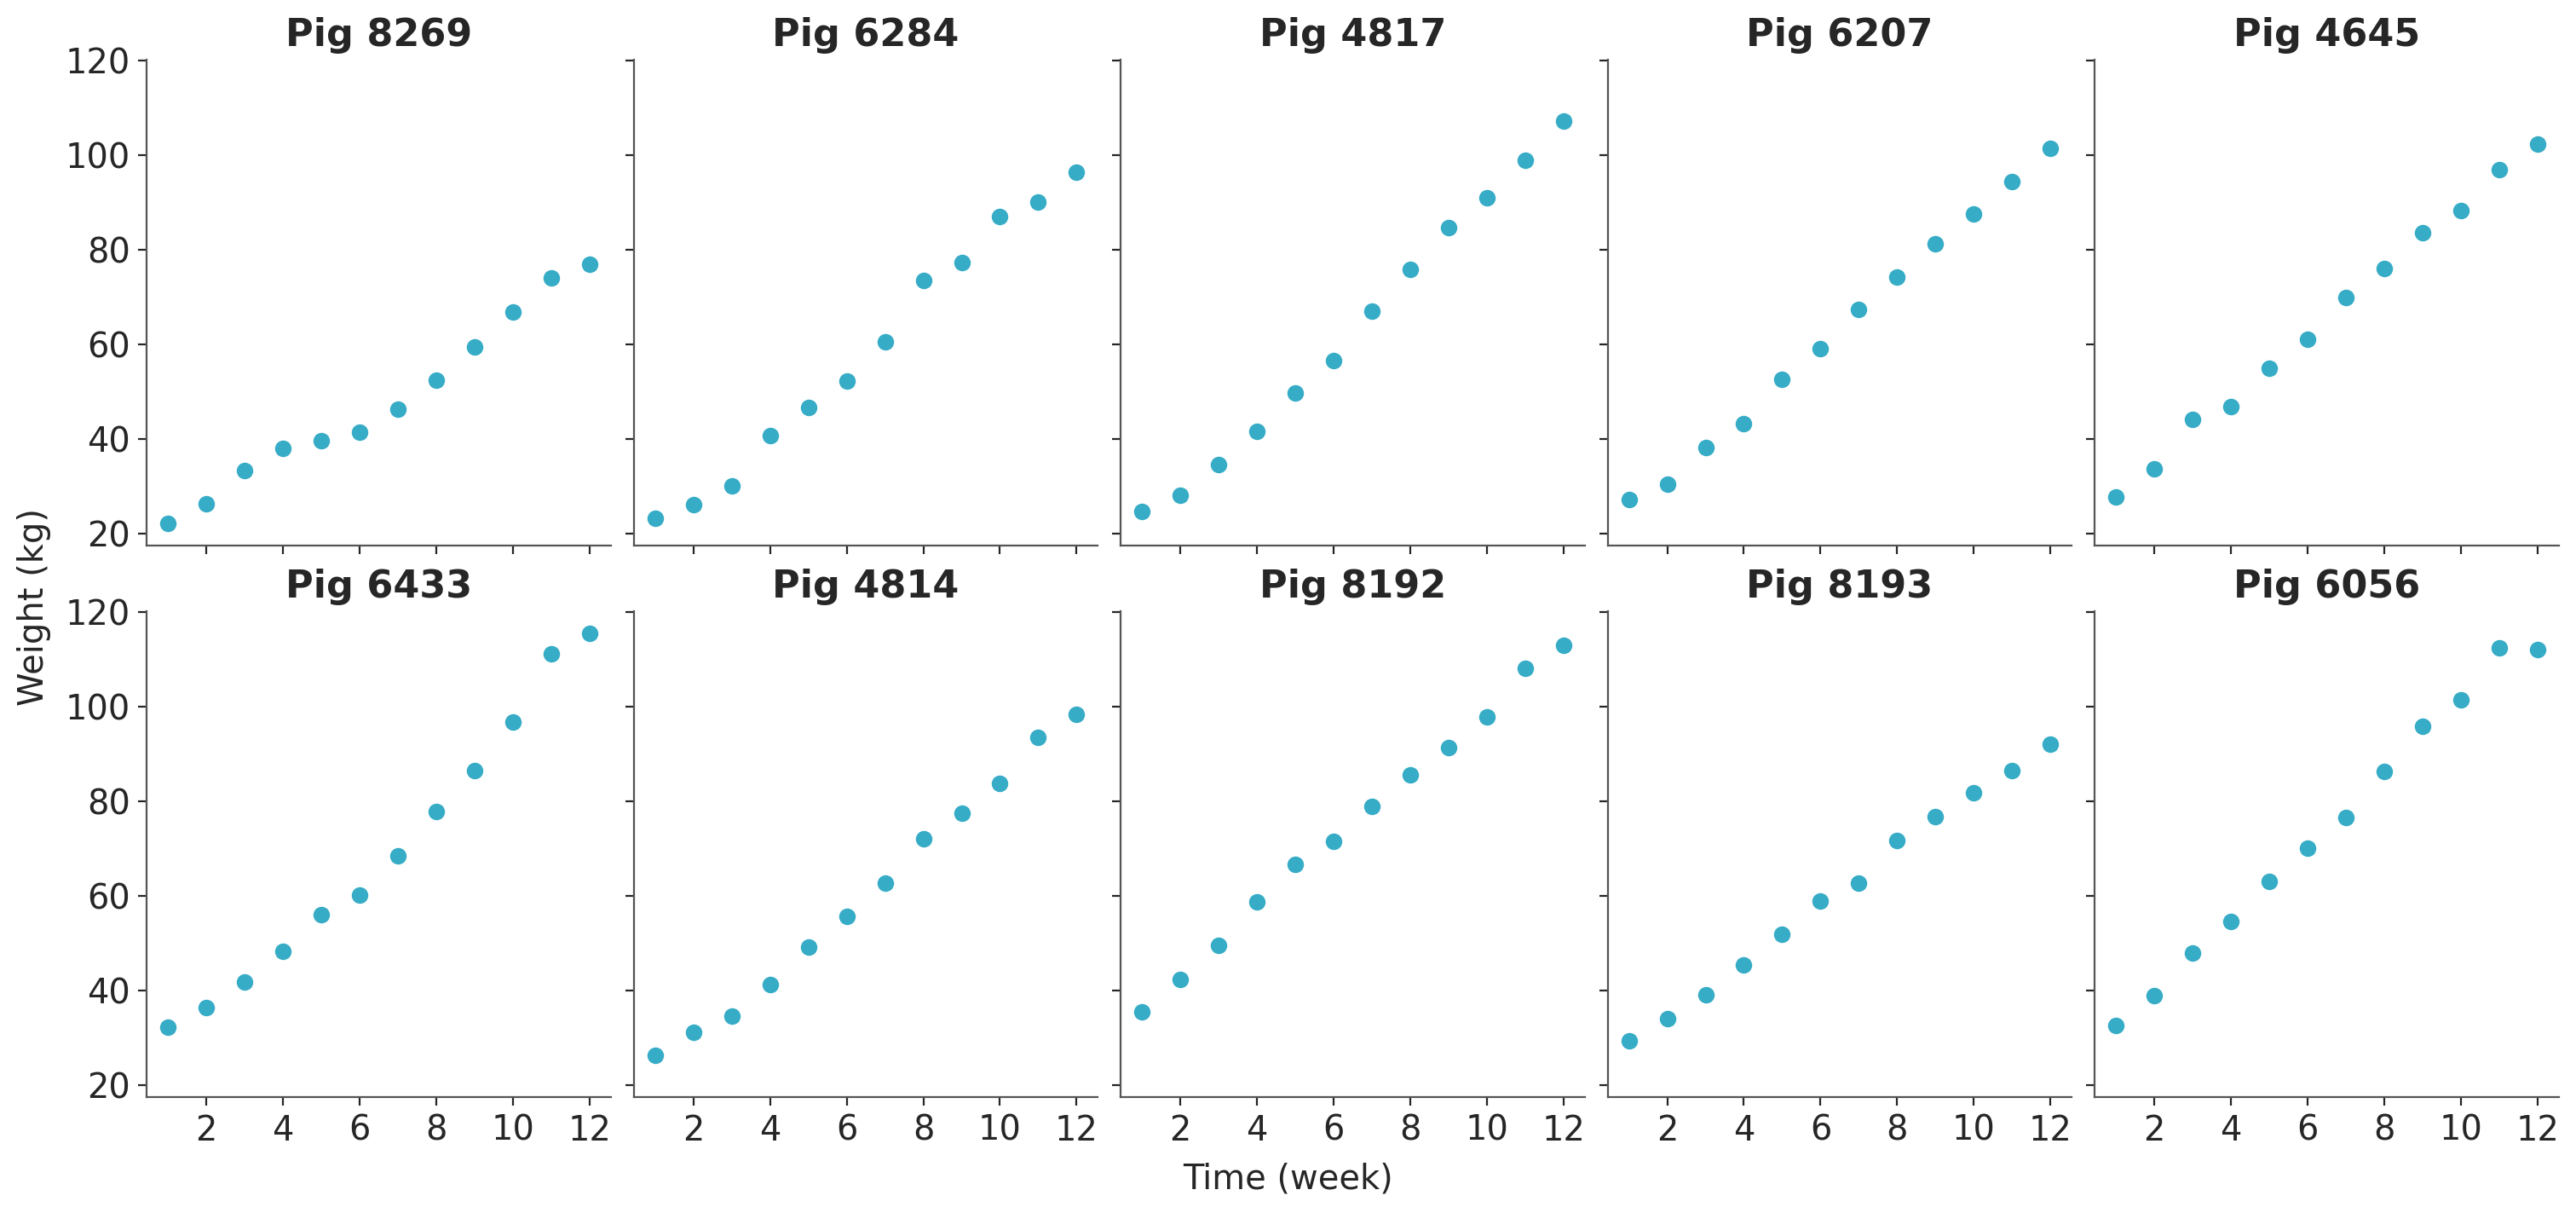

In [3]:
# Time vs Weight for 10 random pigs
rng = np.random.default_rng(SEED)
random_pigs = rng.choice(df["Pig"].unique(), 10, replace=False)

fig, axes = plt.subplots(2, 5, figsize=(15, 7), sharex=True, sharey=True, layout="constrained")

for i, (ax, pig_id) in enumerate(zip(axes.ravel(), random_pigs)):
    pig_data = df[df["Pig"] == pig_id]
    ax.scatter(pig_data["Time"], pig_data["Weight"])
    ax.set_title(f"Pig {pig_id}")

ax.set_xticks([q + 1 for q in range(1, 13, 2)])
fig.supxlabel("Time (week)")
fig.supylabel("Weight (kg)");

From the plot, time and weight seem to be linearly related. 
However, the slope and intercept vary pig by pig. 
So, we'll estimate a model that allows varying intercepts and slopes for time for each pig.

## Model Definition

$$
Y_i = \alpha_i + \beta_i X_i + \epsilon_i
$$

where

$$
\begin{aligned}
\alpha_i &= \alpha_{\text{global}} + \alpha_{\text{specific}, i} \\
\beta_i &= \beta_{\text{global}} + \beta_{\text{specific}, i}
\end{aligned}
$$

So the first equation can be further diluted as

$$
\begin{aligned}
Y_i = \alpha_{\text{global}}+ \alpha_{\text{specific}, i} + [\beta_{\text{global}} + \beta_{\text{specific}, i}]X_i + \epsilon_i \\
\end{aligned}
$$

where $\alpha_{\text{global}}$ and $\beta_{\text{global}}$ are the usual common intercept and slope you find in a linear regression. 
$\alpha_{\text{specific}, i}$ and $\beta_{\text{specific}, i}$ are the group specific components for the pig $i$, influencing its intercept and slope, respectively. 

Finally, $\epsilon_i$ is the random error we always see in these models, assumed to be Gaussian with mean 0 and variance $\sigma^2$.

Note that here we use "common" and "group specific" effects to denote what in many fields are known as "fixed" and "random" effects, respectively.

### PyMC Model

We will first define a PyMC model with the same mathematical conventions used before for better understanding.

We used the `coords` argument inside `pm.Model()` to add dimensionality for our model. 
Also, notice that we passed the `dims` argument only for group-level terms. 
By doing so, we made those terms vectors instead of scalars. 
For example, `α_specific__offset` will have 72 (total number of pigs) independent $\mathcal{N}(0, 1)$ distributions. 
The same can be achieved with the `shape` argument, but using `dims` enhances compatibility with ArviZ.

In [4]:
pig, n_pig = df.Pig.factorize()
coords = {"Pig": n_pig}

with pm.Model(coords=coords) as pymc_model:
    # Common-level effects
    α_global = pm.Normal("α_global", mu=60, sigma=20)
    β_global = pm.Normal("β_global", mu=0, sigma=1)

    # Grou-level effects (non-centered parametrization)
    α_specific_offset = pm.Normal("α_specific_offset", mu=0, sigma=1, dims="Pig")
    α_specific_sigma = pm.HalfNormal("α_specific_sigma", sigma=5)
    β_specific_offset = pm.Normal("β_specific_offset", mu=0, sigma=1, dims="Pig")
    β_specific_sigma = pm.HalfNormal("β_specific_sigma", sigma=1)

    α_specific = pm.Deterministic("α_specific", α_specific_offset * α_specific_sigma, dims="Pig")
    β_specific = pm.Deterministic("β_specific", β_specific_offset * β_specific_sigma, dims="Pig")

    # Standard deviation of Y | X (the same as the standard deviation of epsilon_i)
    σ = pm.HalfStudentT("σ", nu=4, sigma=10)

    # Build mu_i
    α = α_global + α_specific[pig]
    β = β_global + β_specific[pig]
    μ = pm.Deterministic("μ", α + β * df["Time"])

    # Observational model
    Y = pm.Normal("Weight", mu=μ, sigma=σ, observed=df["Weight"])

    # Sampling
    pymc_idata = pm.sample(random_seed=SEED)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [α_global, β_global, α_specific_offset, α_specific_sigma, β_specific_offset, β_specific_sigma, σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 9 seconds.


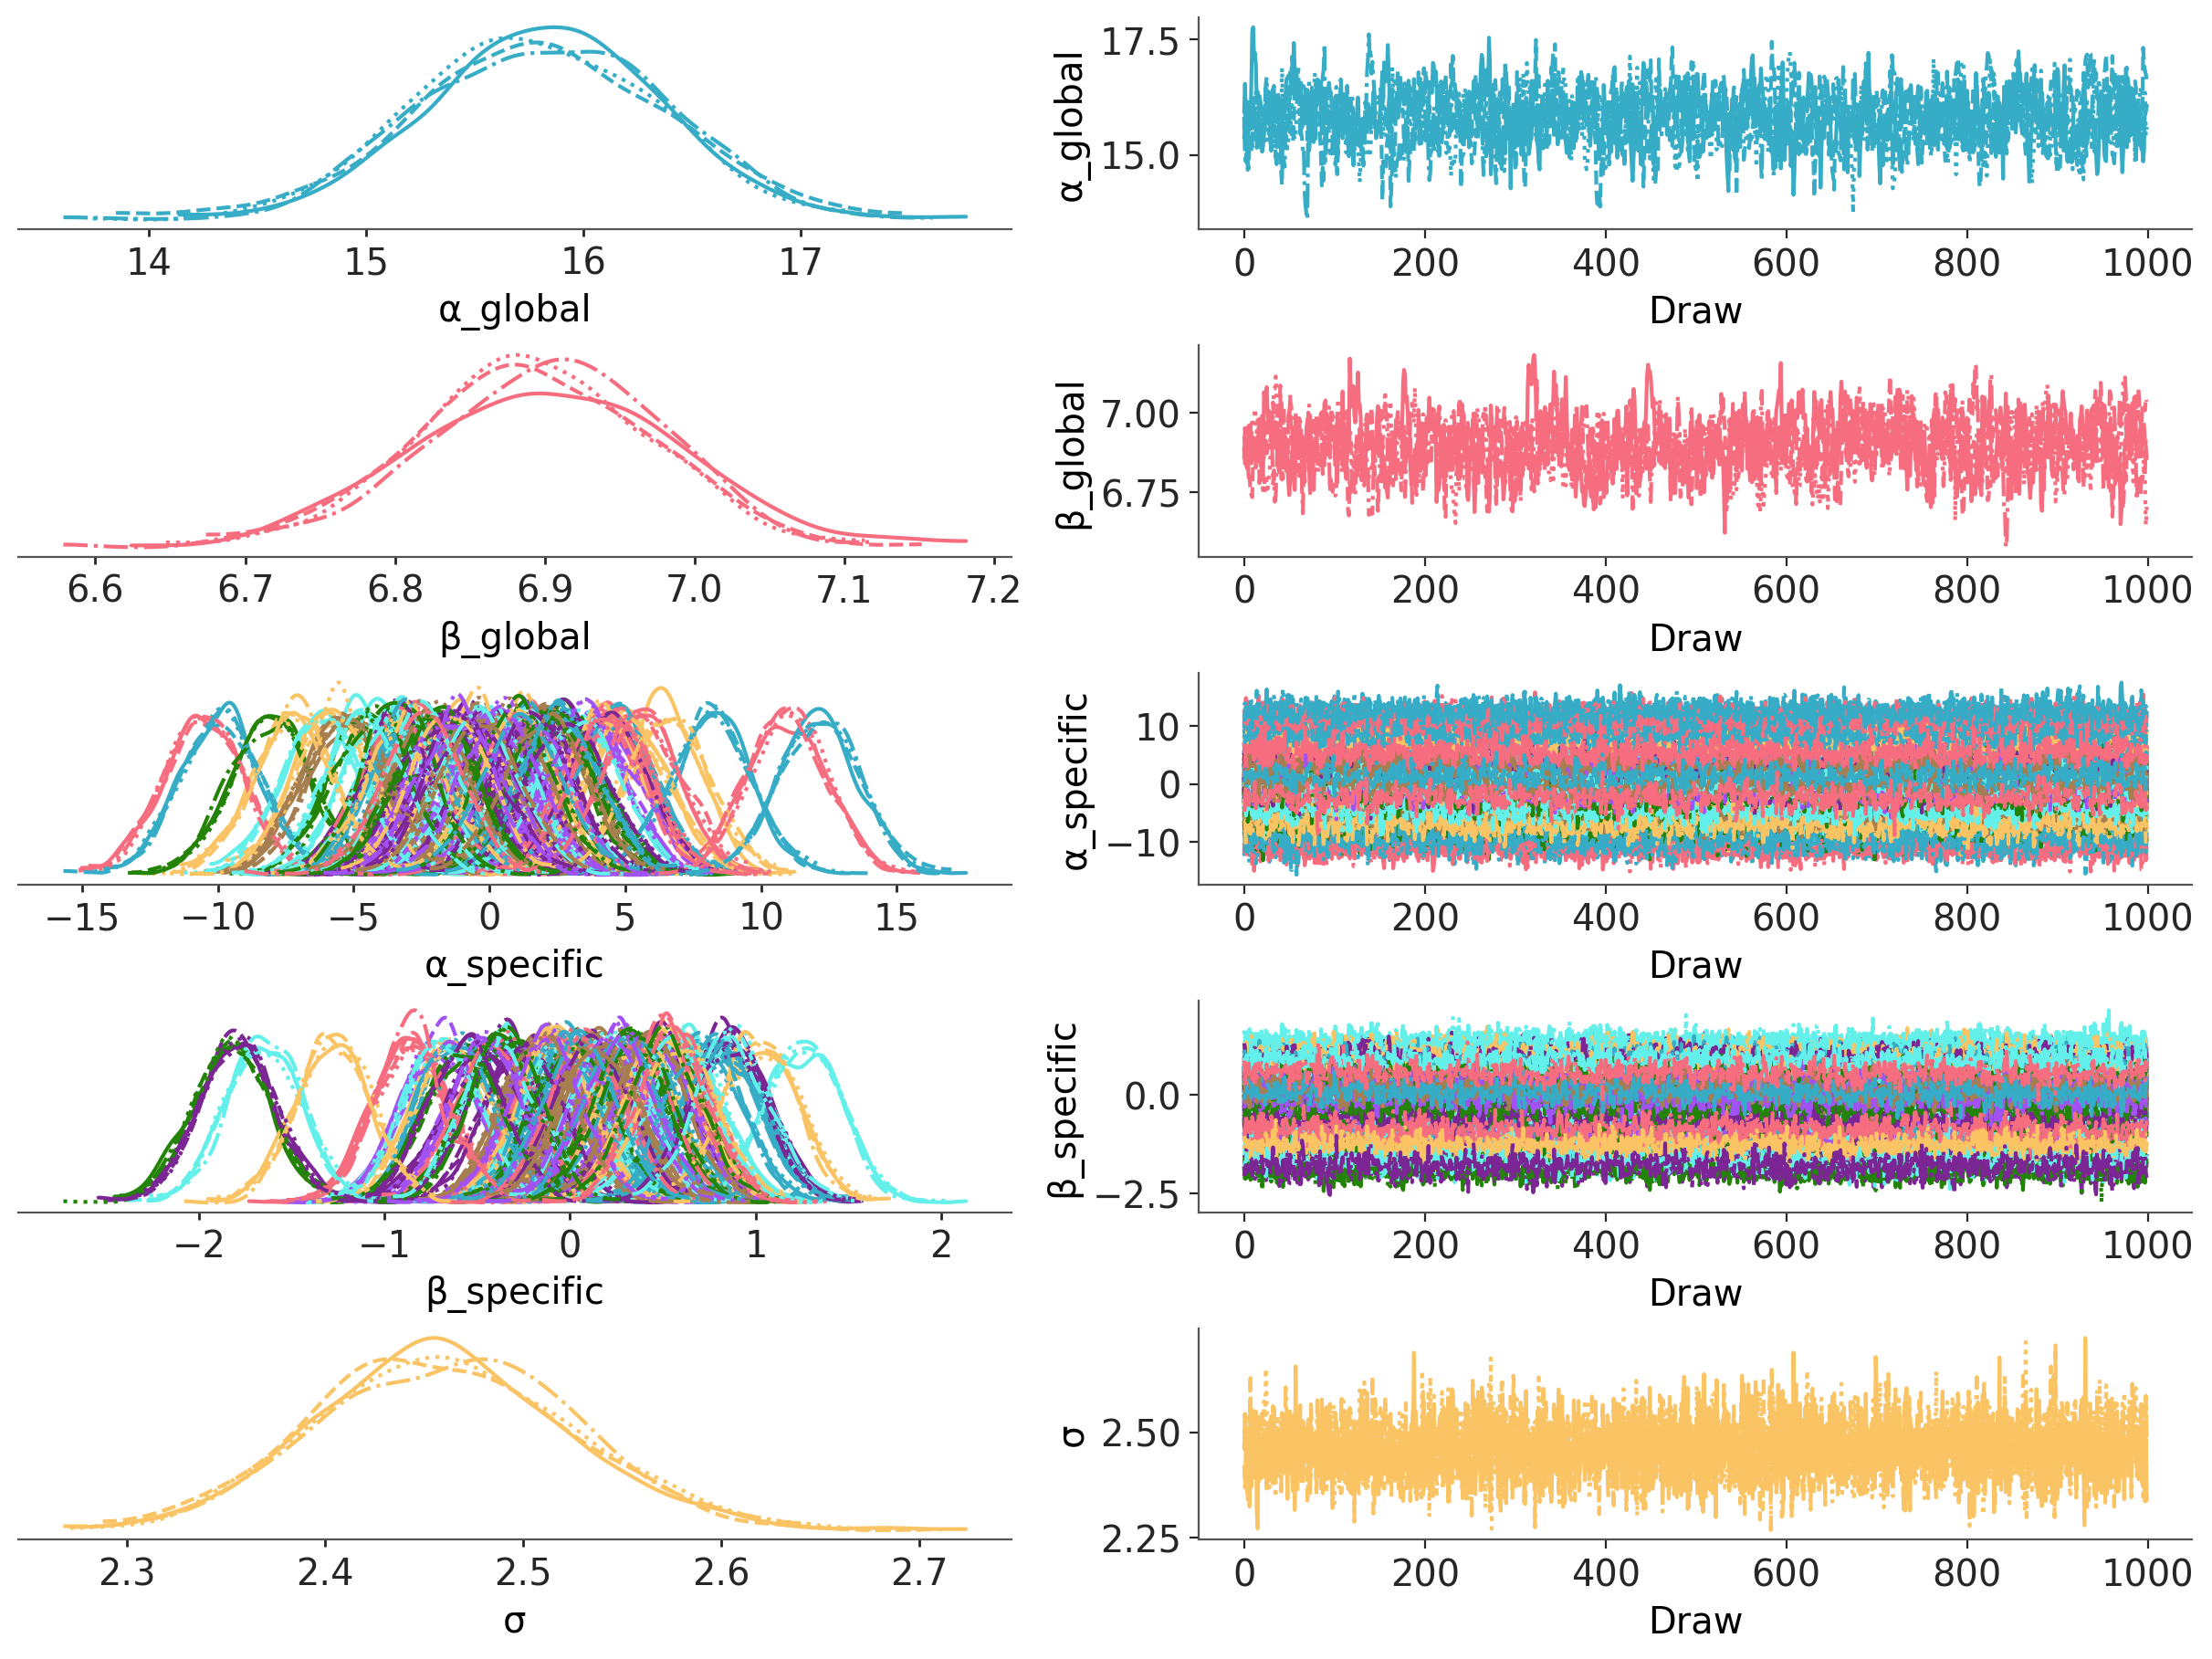

In [5]:
azp.plot_trace_dist(
    pymc_idata, 
    var_names=["α_global", "β_global", "α_specific", "β_specific", "σ"],
);

### Bambi Model

In Bambi, we use the formula syntax to specify the model. Previously in PyMC, we specified common and group specific components separately. 
Now, thanks to [formulae](https://github.com/bambinos/formulae), you can specify model formulas just as you would do with R packages like [lme4](https://CRAN.R-project.org/package=lme4) and [brms](https://CRAN.R-project.org/package=brms). 

In a nutshell, the term on the left side tells `Weight` is the response variable, `Time` on the right-hand side tells we include a main effect for the variable `Time`, and `(Time|Pig)` indicates we want to allow a each pig to have its own slope for `Time` as well as its own intercept (which is implicit). 

If we only wanted different intercepts, we would have written `Weight ~ Time + (1 | Pig)` and if we wanted slopes specific to each pig without including a pig specific intercept, 
we would write `Weight ~ Time + (0 + Time | Pig)`.

In [6]:
bmb_model = bmb.Model("Weight ~ Time + (Time|Pig)", df)
bmb_model # Inspect the model

       Formula: Weight ~ Time + (Time|Pig)
        Family: gaussian
          Link: mu = identity
  Observations: 861
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 60.7258, sigma: 133.0346)
            Time ~ Normal(mu: 0.0, sigma: 18.1283)
        
        Group-level effects
            1|Pig ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 133.0346))
            Time|Pig ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 18.1283))
        
        Auxiliary parameters
            sigma ~ HalfStudentT(nu: 4.0, sigma: 24.9644)

Referring to the above section, we had explicitly defined all the priors. 
But here, Bambi has chosen sensible defaults for us.

We can explore these priors through samples generated from them with a call to the [`.plot_priors`](`bambi.Model.plot_priors`) method, 
which plots a kernel density estimate for each prior.

Sampling: [1|Pig_sigma, Intercept, Time, Time|Pig_sigma, sigma]


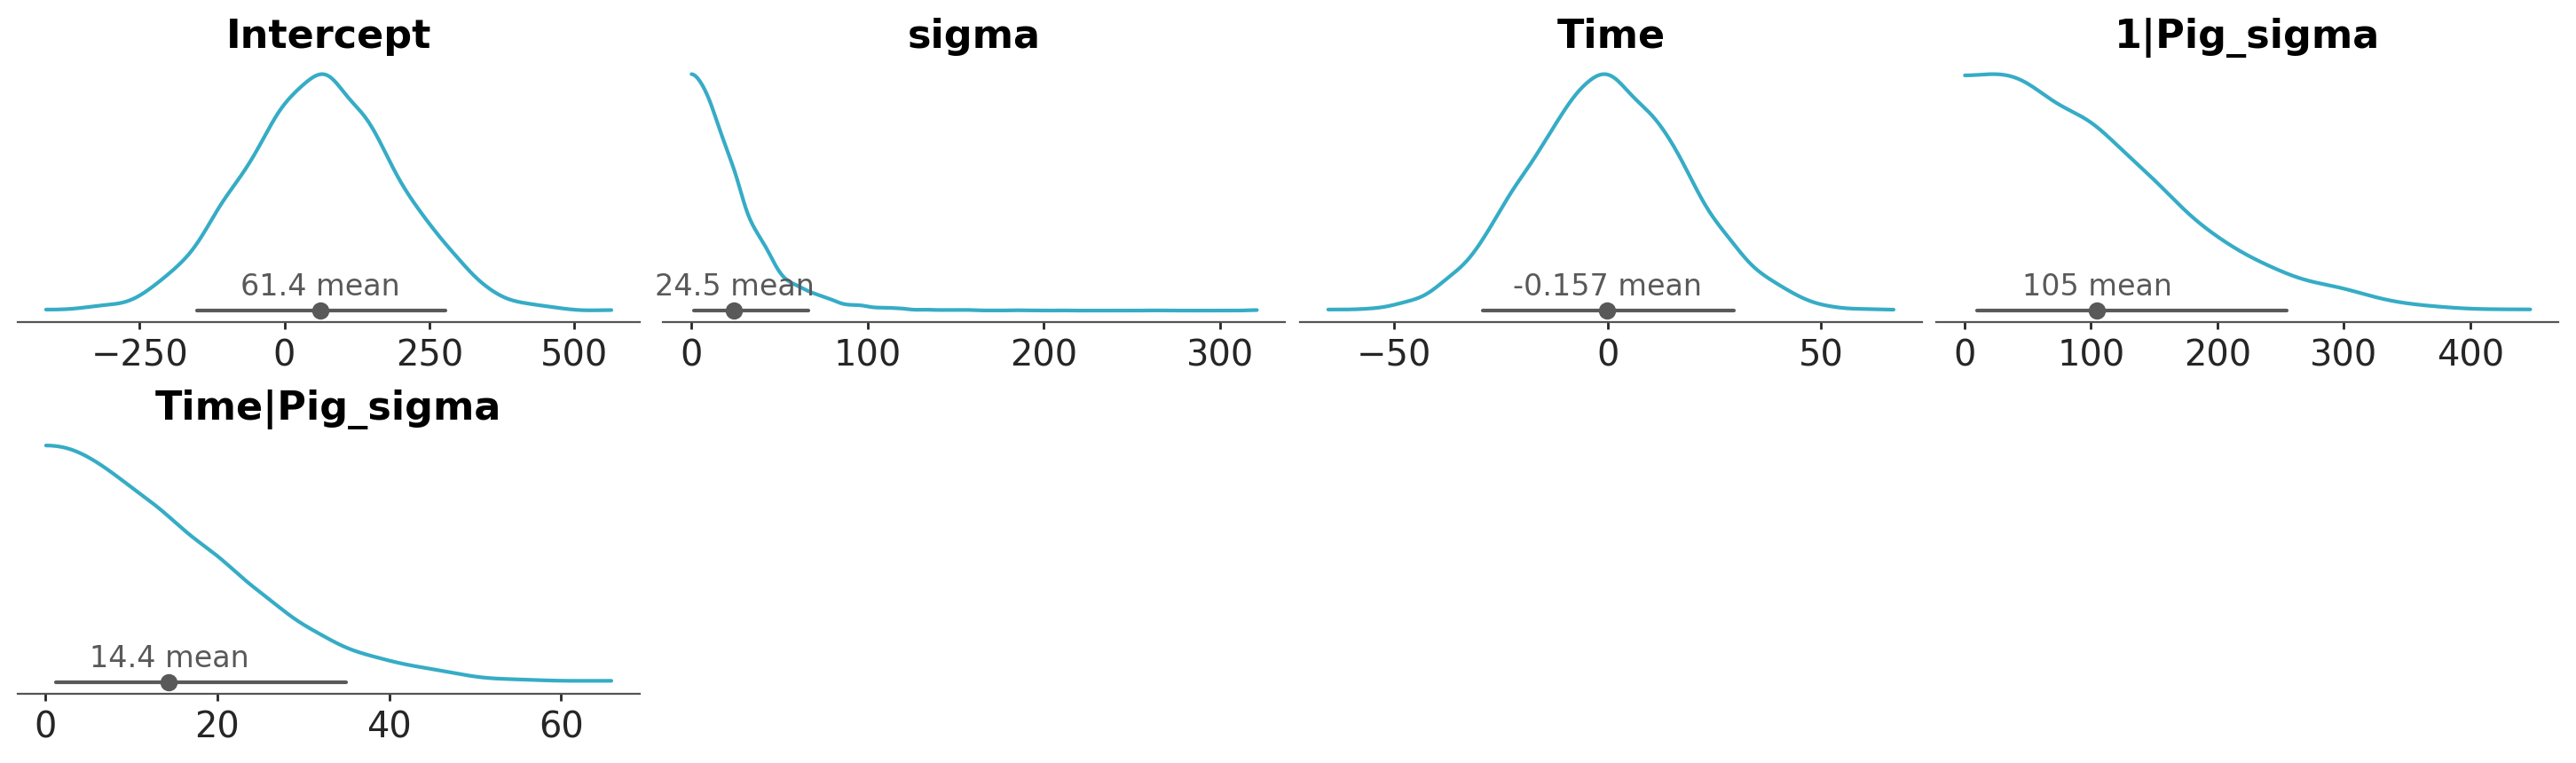

In [7]:
bmb_model.build()
bmb_model.plot_priors();

Both models are literally the same. Take a moment to inspect and compare the graphical representation of both models using `bmb_model.graph()` and `pymc_model.to_graphviz()` . It will help to understand how the parameters in Bambi are related to our mathematical (or PyMC) representation.

Let's now fit the model via the `.fit()` method:

In [8]:
bmb_idata = bmb_model.fit(random_seed=SEED)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, Time, 1|Pig_sigma, 1|Pig_offset, Time|Pig_sigma, Time|Pig_offset]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 8 seconds.


## Forest plots

Now we are ready to check the results. We can get credible interval plots from forest plots using ArviZ. 

Here, the thin line indicates a 94% credible interval calculated as higher posterior density, 
the thicker line represents the 50% interval, and the dot is the median. 

We also made a comparison between a few parameters. We can quickly note a few things:

 - Both the models ended up in the same posterior, even with different priors, as a result of the amount of information in the data.
 - The credible interval for `Time` is far from 0, so we can be confident there's a positive relationship between the `Weight` of the pigs and `Time`. As expected!

We're not making any great discoveries by stating that, as time passes, we expect the pigs to weigh more. 
Still, this very simple example can be used as a starting point in applications where the relationship between the variables is not that clear beforehand.

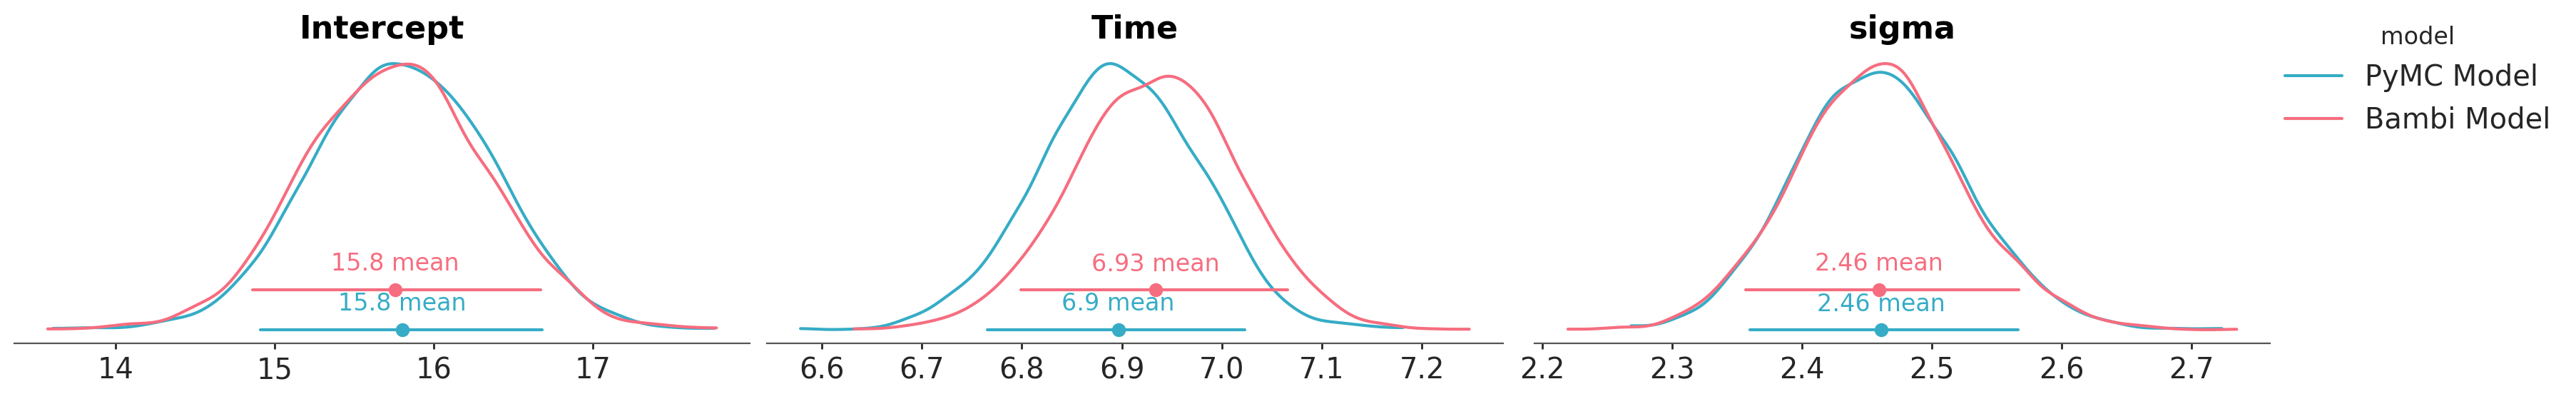

In [9]:
# Rename PyMC variables to match Bambi names, so ArviZ can automatically match them
pymc_idata_renamed = pymc_idata.copy()
pymc_idata_renamed.posterior = pymc_idata_renamed.posterior.rename({
    "α_global": "Intercept",
    "β_global": "Time", 
    "σ": "sigma"
})

# Now plot with matching variable names
pc = azp.plot_dist(
    {"PyMC Model": pymc_idata_renamed, "Bambi Model": bmb_idata},
    var_names=["Intercept", "Time", "sigma"],
);
pc.add_legend("model");

## Trace plots

Using `az.plot_trace()` we get traceplots that show the values sampled from the posteriors and density estimates that gives us an idea of the shape of the marginal posteriors of our parameters. 

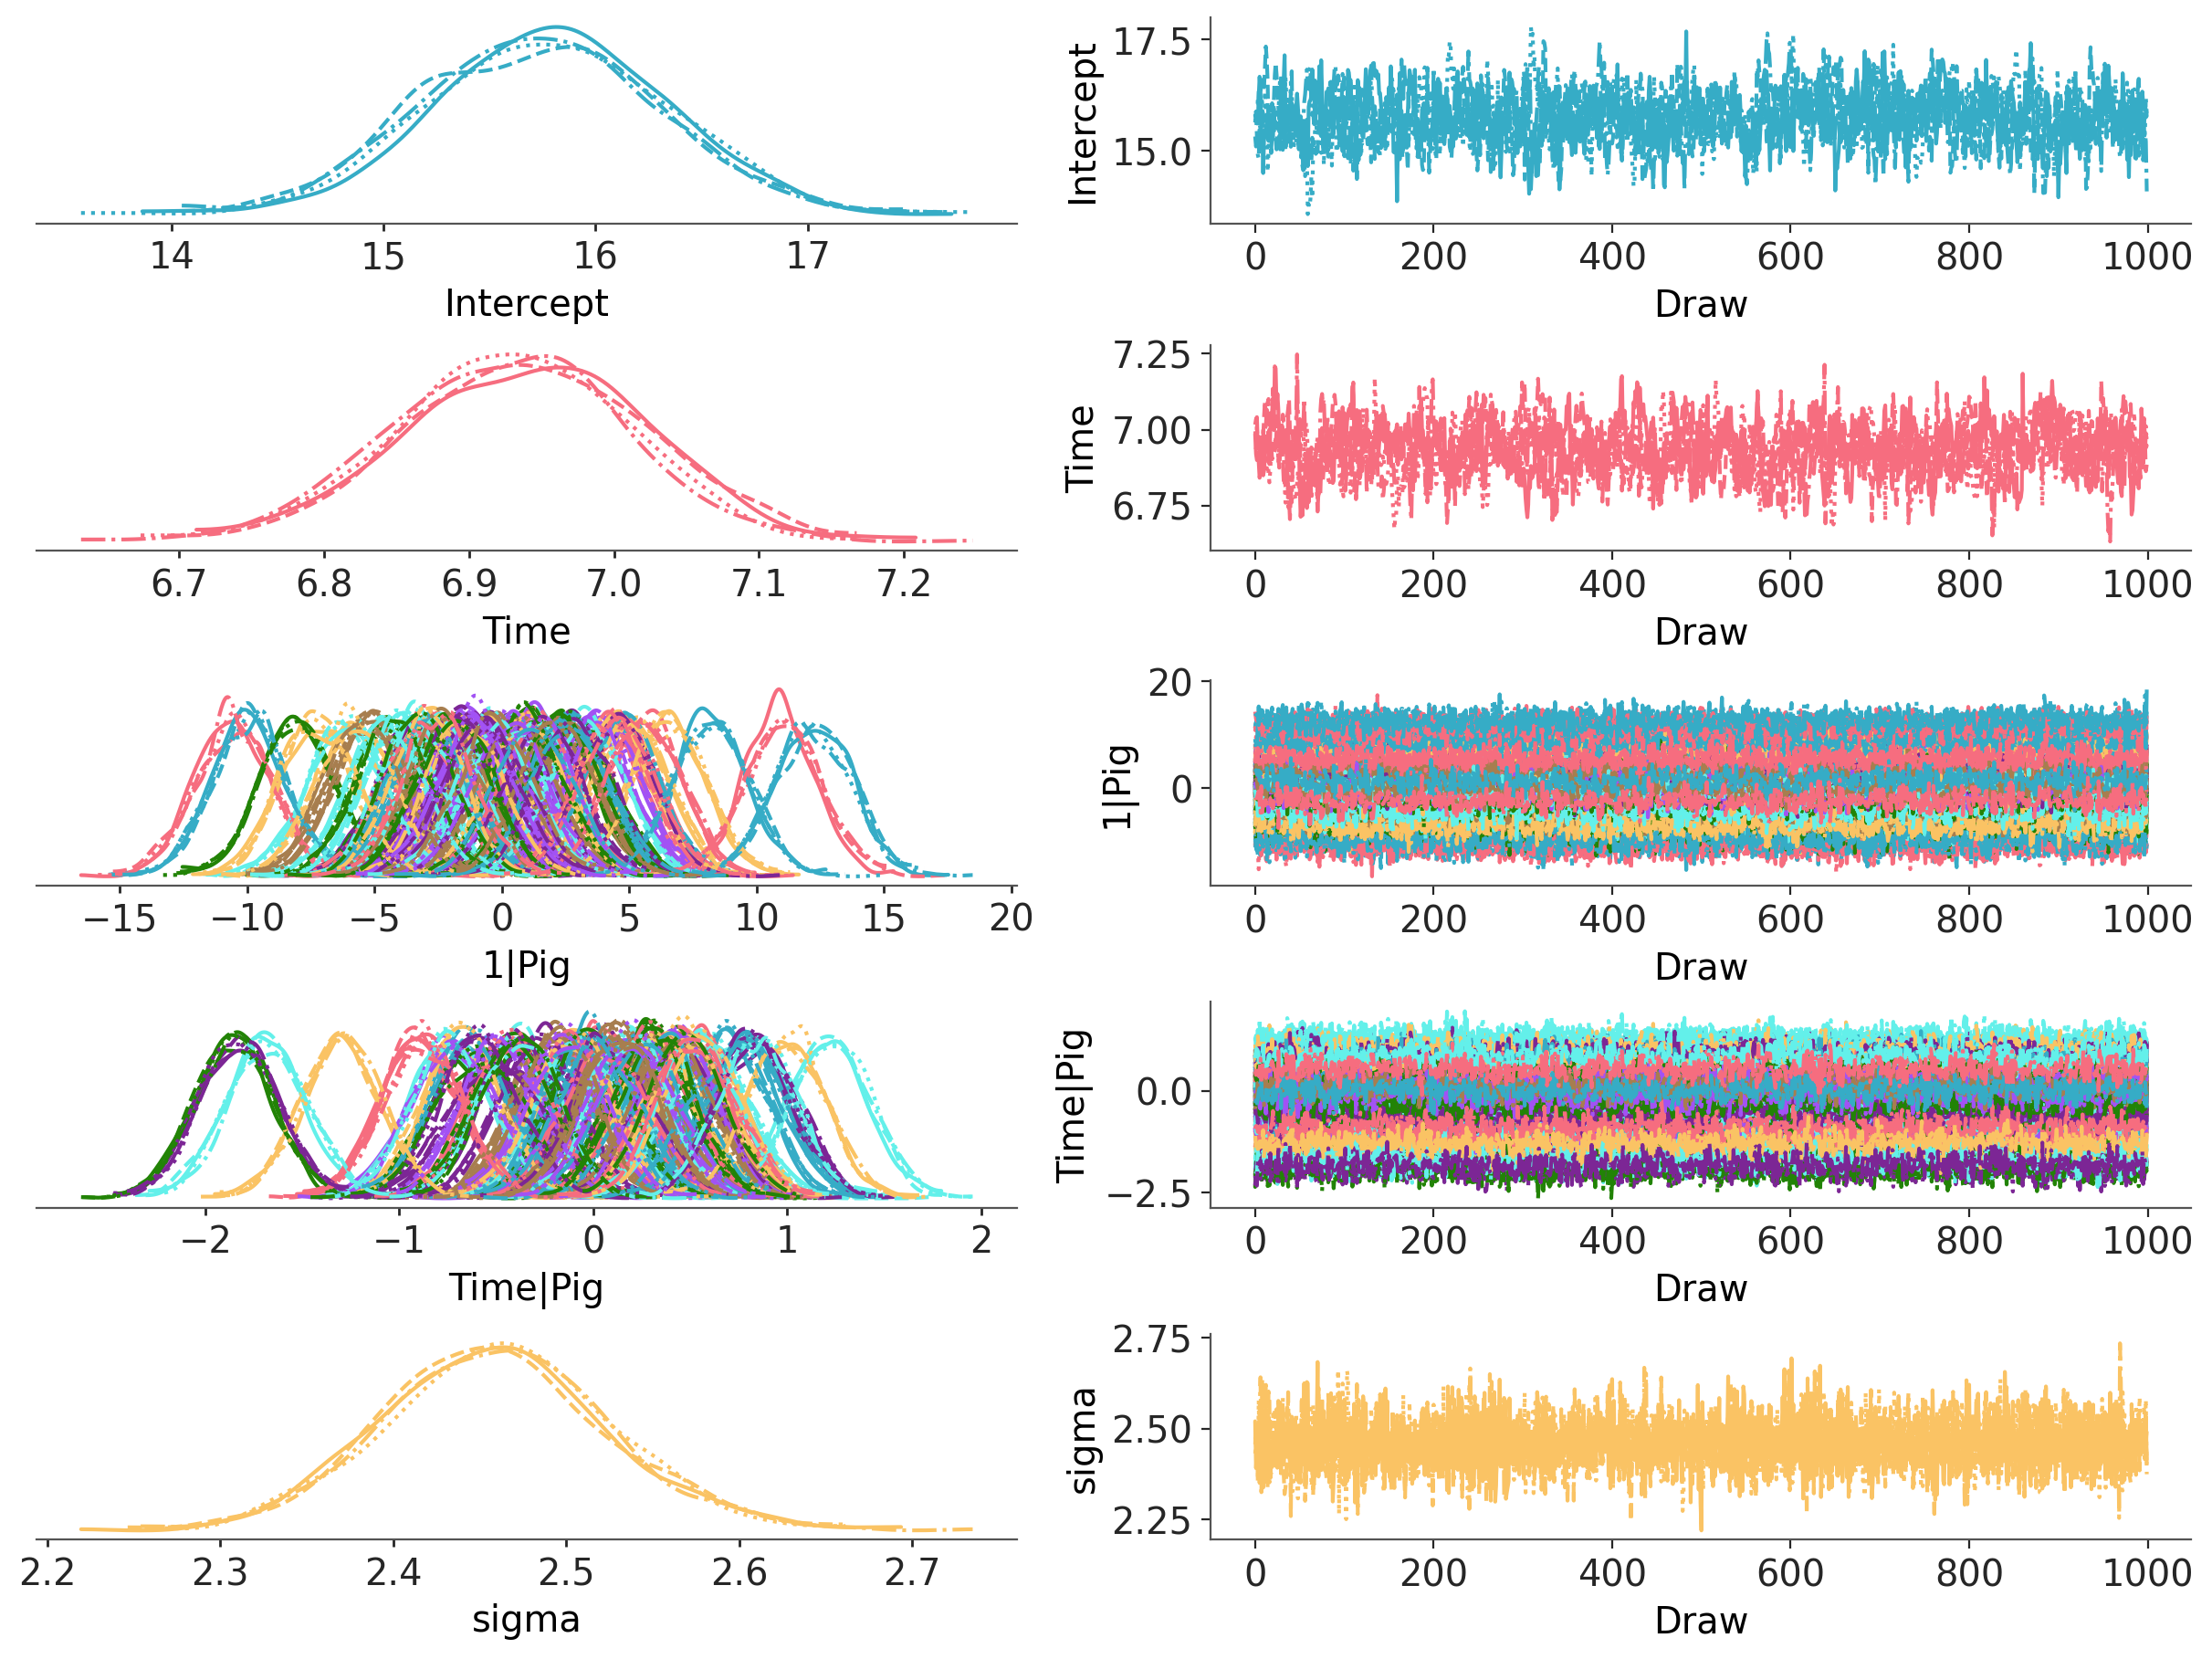

In [10]:
azp.plot_trace_dist(
    bmb_idata,
    var_names=["Intercept", "Time", "1|Pig", "Time|Pig", "sigma"],
);

The same plot could have been generated with less typing by calling 

`az.plot_trace(bmb_idata, var_names=["~1|Pig_sigma", "~Time|Pig_sigma"]);`

which uses an alternative notation to pass `var_names` based on the negation symbol in Python, `~`. 
There we are telling ArviZ to plot all the variables in the InferenceData object `bmb_idata`, except from `1|Pig_sigma` and `Time|Pig_sigma`. 

## Posterior summary

The plots generated by `az.plot_trace()` are enough to be confident that the sampler did a good job and conclude about plausible values for the distribution of each parameter in the model. But if we want to, and it is a good idea to do it, we can get numerical summaries for the posteriors with `az.summary()`.

In [11]:
azs.summary(
    bmb_idata,
    var_names=["Intercept", "Time", "1|Pig_sigma", "Time|Pig_sigma", "sigma"],
)

mean    sd  eti89_lb  eti89_ub  ess_bulk  ess_tail  r_hat  \
Intercept       15.76  0.57     14.86     16.67    649.67   1101.71   1.01   
Time             6.93  0.08      6.80      7.07    599.48    944.55   1.01   
1|Pig_sigma      4.55  0.45      3.87      5.29   1205.94   1637.77   1.00   
Time|Pig_sigma   0.66  0.06      0.57      0.77    986.08   1753.84   1.00   
sigma            2.46  0.07      2.36      2.57   5823.05   3169.36   1.00   

                mcse_mean  mcse_sd  
Intercept            0.02     0.02  
Time                 0.00     0.00  
1|Pig_sigma          0.01     0.01  
Time|Pig_sigma       0.00     0.00  
sigma                0.00     0.00

## Estimated regression line

Here we'll visualise the regression equations we have sampled for a few particular pigs, and then we'll compare the mean regression equation for all 72 pigs in the dataset.  

The following plot shows the 94% HDI from 4000 (4 chains x 1000 draws each) linear regressions for 10 random pigs, the same pigs previously plotted in the EDA. The mean regression line is plotted in black, and the pink dots represent the observed weights for this pig.

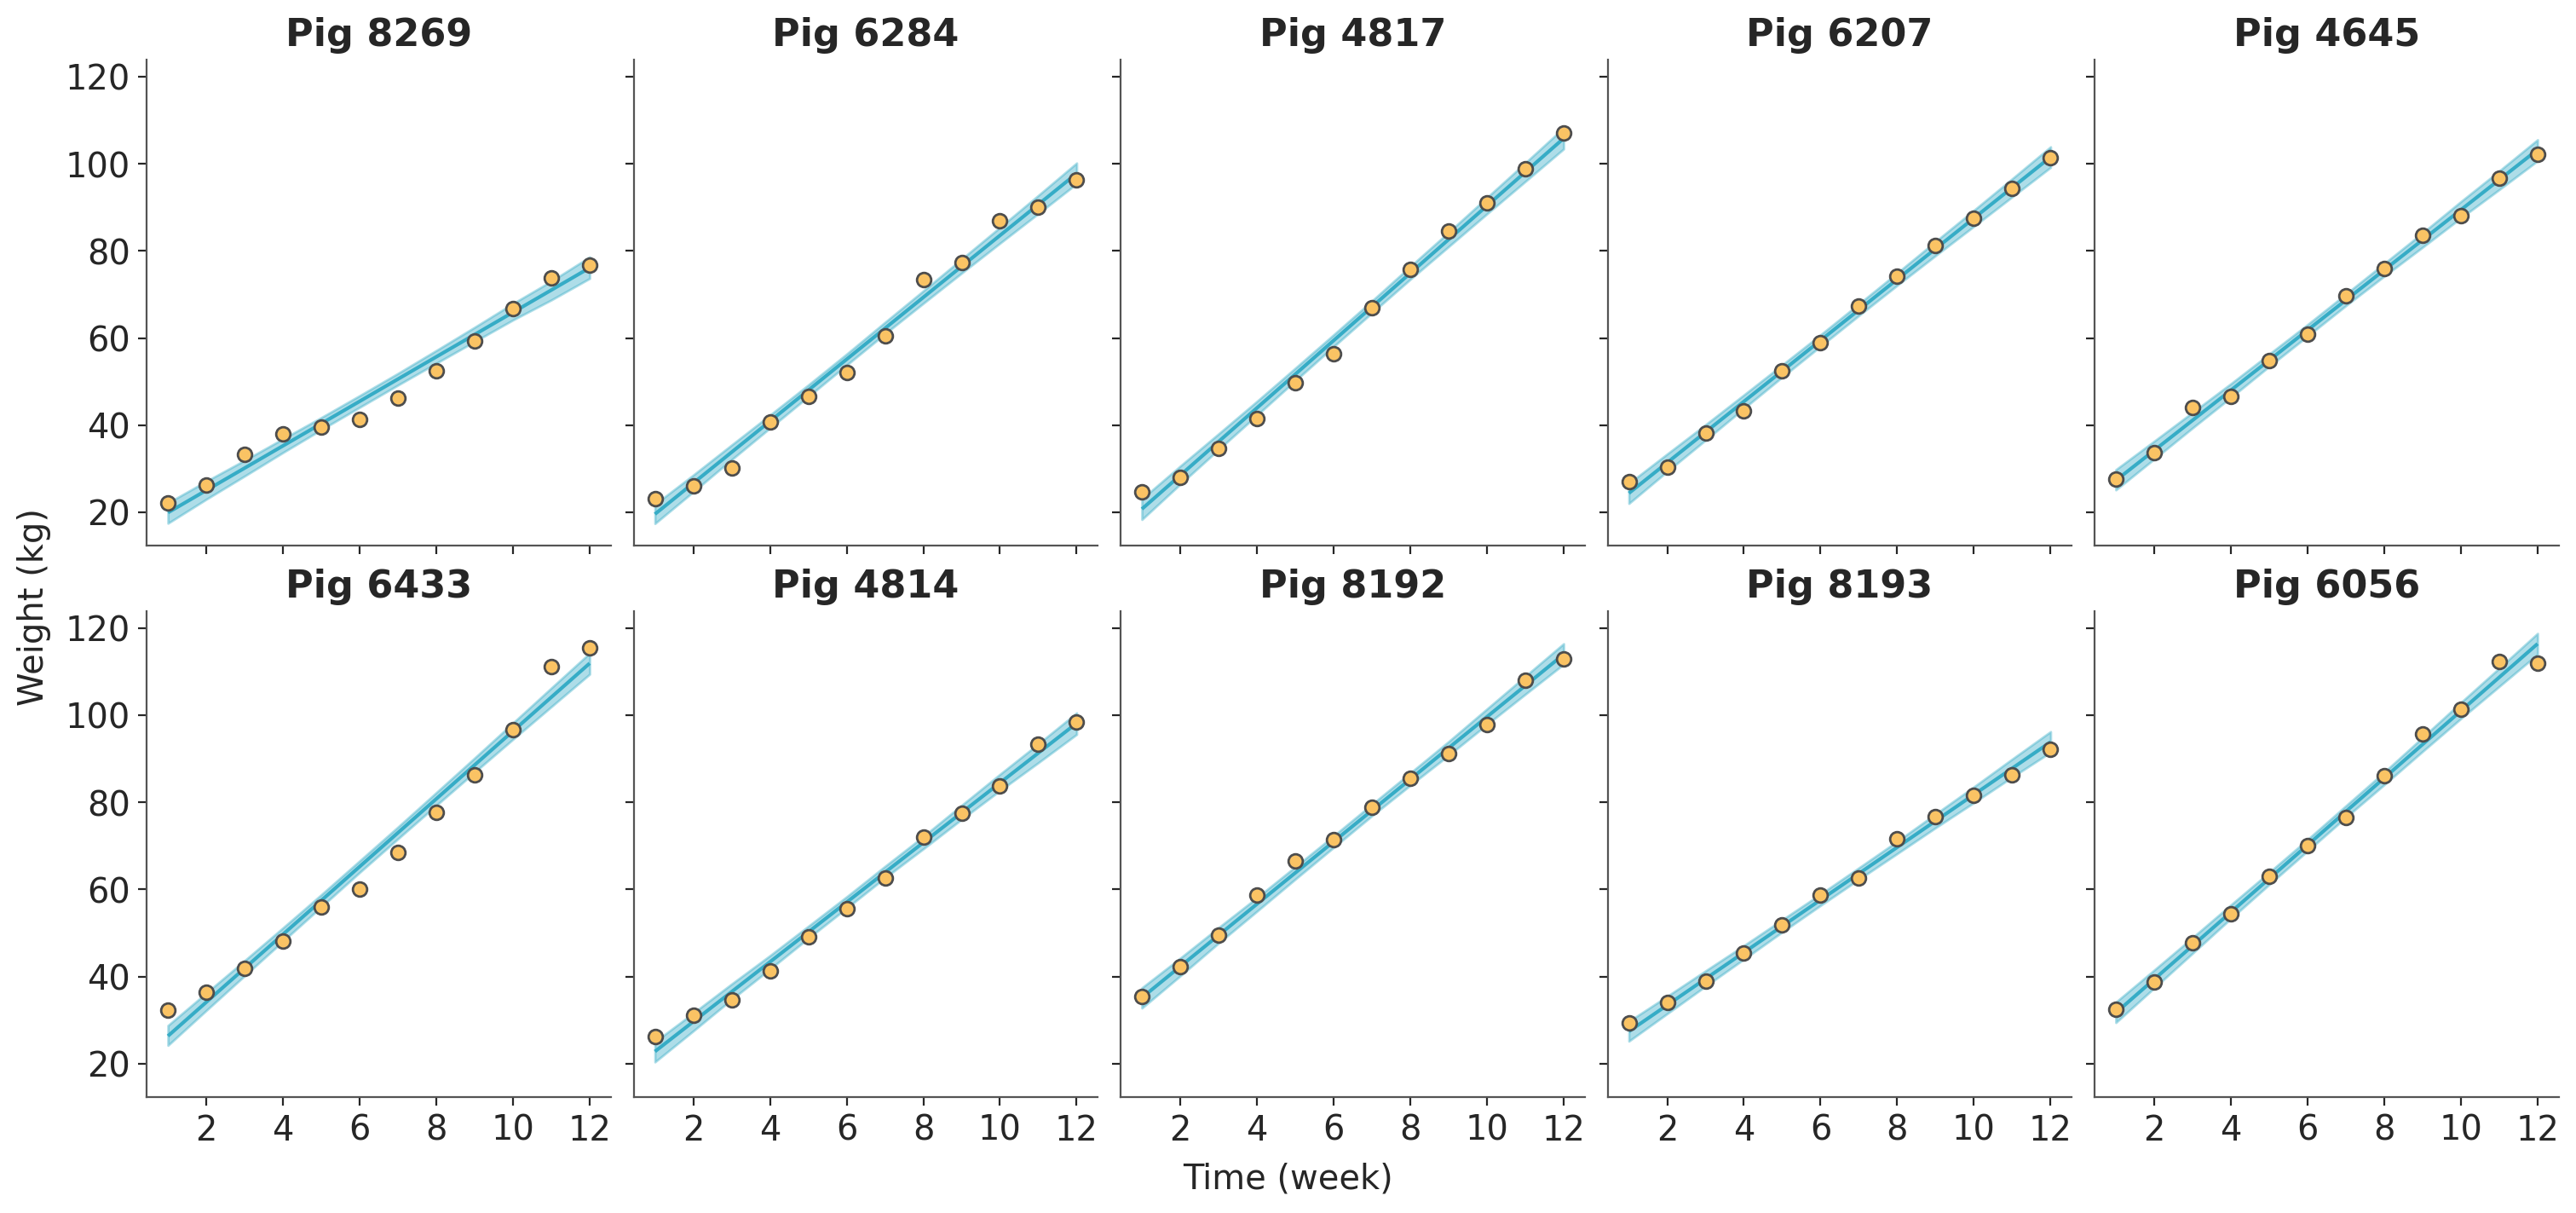

In [12]:
time = np.array(range(1, 13))

fig, axes = plt.subplots(2, 5, figsize=(15, 7), sharex=True, sharey=True, layout="constrained")

for i, (ax, pig_id) in enumerate(zip(axes.ravel(), random_pigs)):
    pig_data = df[df["Pig"] == pig_id]
    bmb.interpret.plot_predictions(
        model=bmb_model,
        idata=bmb_idata,
        conditional={"Time": time, "Pig": pig_id},
        ax=ax,
        legend=False,
    )
    ax.scatter(pig_data["Time"], pig_data["Weight"], color="C2", ec="0.3", zorder=10)
    ax.set(title=f"Pig {pig_id}", xlabel=None, ylabel=None)

ax.set_xticks([q + 1 for q in range(1, 13, 2)])
fig.supxlabel("Time (week)")
fig.supylabel("Weight (kg)");

Next, we calculate the mean regression line for each pig and show them together in one plot. Here we clearly see each pig has a different pair of intercept and slope.

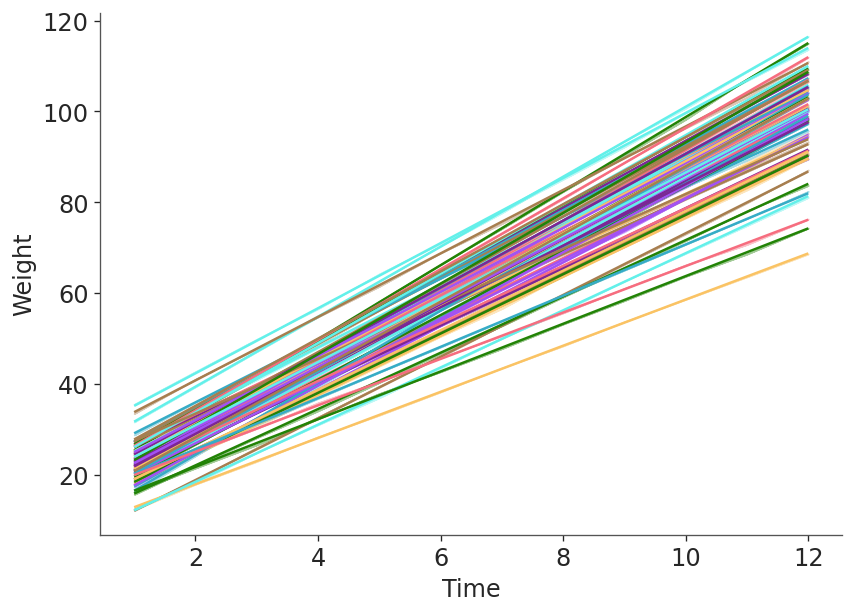

In [13]:
bmb.interpret.plot_predictions(
    model=bmb_model,
    idata=bmb_idata,
    conditional={"Time": time, "Pig": df.Pig.unique()},
    prob=0.01, # To 'remove' intervals
    legend=False,
    fig_kwargs={"dpi": 120, "figsize": (7, 5)}
);

We can also plot the posterior overlaid with a region of practical equivalence (ROPE). This region indicates a range of parameter values that are considered to be practically equivalent to some reference value of interest to the particular application, for example 0. In the following plot we can see that the marginals posterior distributions for `Intercept` and `Time` fall outside of this range.

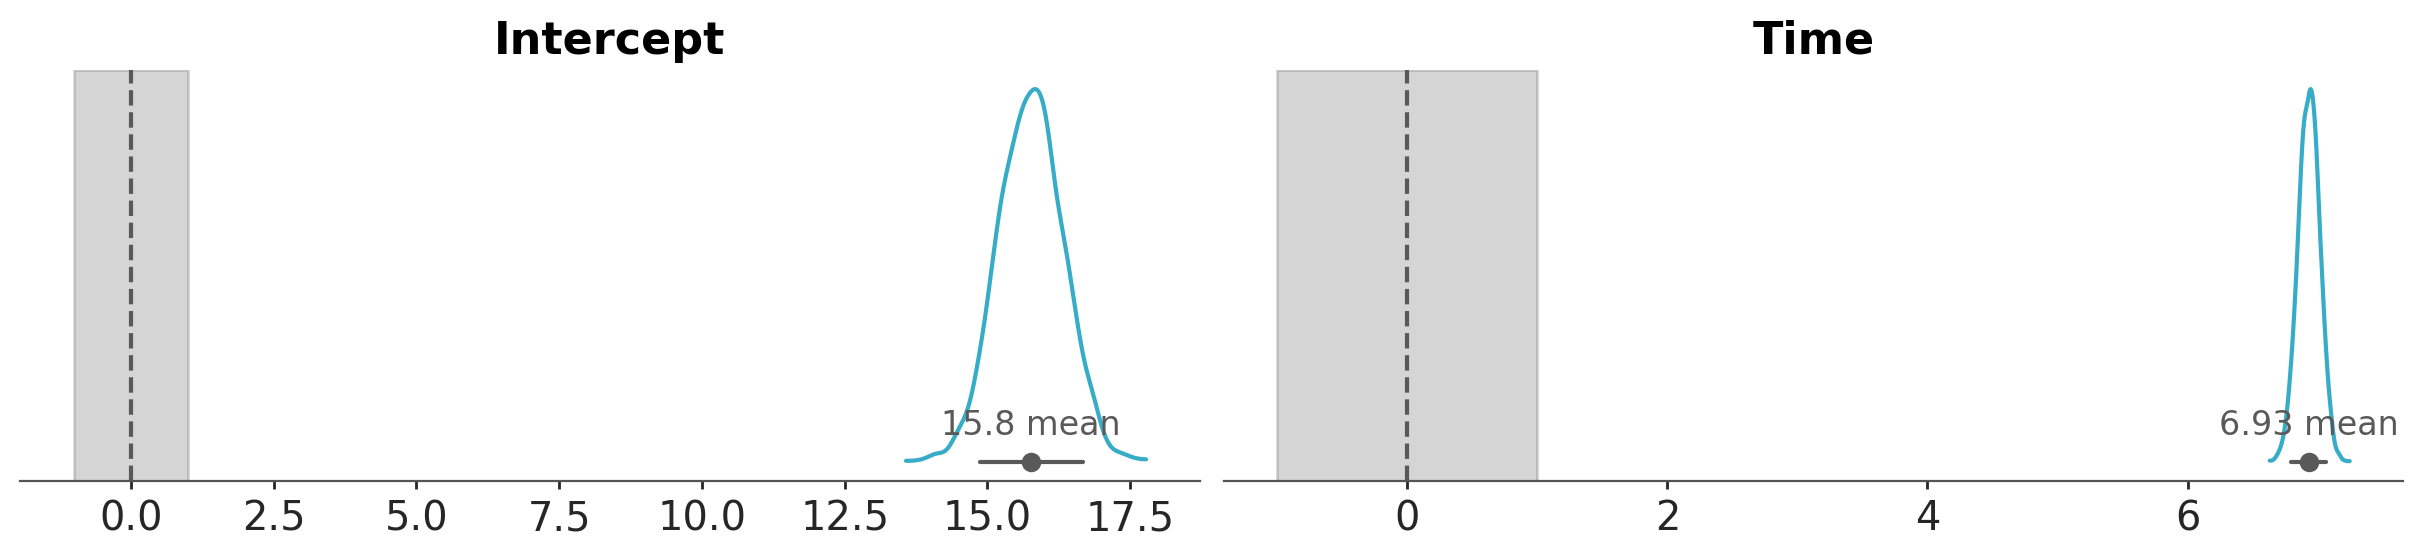

In [14]:
pc = azp.plot_dist(bmb_idata, var_names=["Intercept", "Time"])
azp.add_lines(pc, 0)
azp.add_bands(pc, [(-1, 1)]);

In [15]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Mon Nov 24 2025

Python implementation: CPython
Python version       : 3.13.0
IPython version      : 9.1.0

bambi      : 0.12.1.dev100+g8722a1ff3.d20250827
arviz_plots: 0.7.0
pymc       : 5.26.1
statsmodels: 0.14.5
numpy      : 2.2.4
arviz_stats: 0.7.0
matplotlib : 3.10.1

Watermark: 2.5.0

